# 1. Import modules

In [1]:
import json
import numpy as np
import random
import sys
import time
import cv2
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.utils import np_utils,plot_model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout
from keras.optimizers import Adam
from sklearn import model_selection
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from matplotlib import pyplot as plt

Using TensorFlow backend.


# 2. Download and study the dataset

## 2.1 Load data

In [2]:
with open('/Users/howard/Desktop/ECE228/Project/Data/shipsnet.json') as f:
    dataset=json.load(f)
data_images=np.array(dataset['data']).astype('uint8')
data_labels=np.array(dataset['labels']).astype('uint8')

In [3]:
data_images.shape

(2800, 19200)

The dataset contains 2800 images, each of which is represented as a vector of length 19200 elements. 

In [4]:
data_labels.shape

(2800,)

In [5]:
print(list(data_labels).count(0))
print(list(data_labels).count(1))

2100
700


The dataset contains 700 positive samples labeled as 1, and 2100 negative samples labeled as 0.

## 2.2 Visualize one image

### 2.2.1 Convert into RGB matrix

In [6]:
n_chanels=3
height=80
width=80
X=data_images.reshape([-1,n_chanels,height,width])
print(X.shape)
print(X[0].shape)

(2800, 3, 80, 80)
(3, 80, 80)


### 2.2.2 Visualize

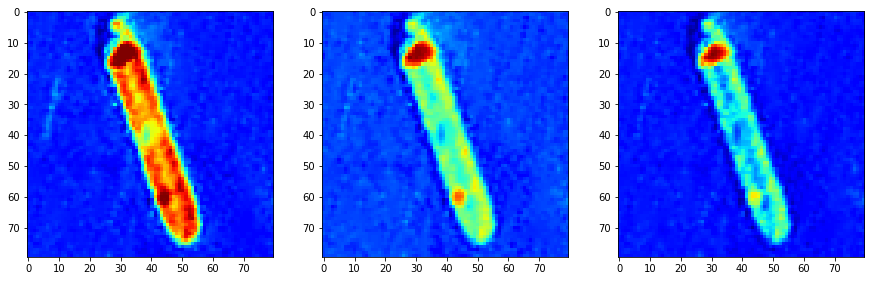

In [7]:
pic=X[0]
red_chanel=pic[0]
green_chanel=pic[1]
blue_chanel=pic[2]

plt.figure(figsize=(5*3,5*1))
plt.set_cmap('jet')

plt.subplot(131)
plt.imshow(red_chanel)

plt.subplot(132)
plt.imshow(green_chanel)

plt.subplot(133)
plt.imshow(blue_chanel)

plt.show()

# 3. Binary-Classification Algorithms Comparison

## 3.1 Define compare functions

In [8]:
def CompareModels(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models=[]
    models.append(('LR',LogisticRegression()))
    models.append(('RF',RandomForestClassifier()))
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('SVM',SVC()))
    resultsAccuracy=[]
    names=[]
    for name,model in models:
        model.fit(a,b)
        kfold=model_selection.KFold(n_splits=10,random_state=42)
        accuracy_results=model_selection.cross_val_score(model,a,b,cv=kfold,scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage="%s: %f (%f)"%(name,accuracy_results.mean(),accuracy_results.std())
        print(accuracyMessage)
    fig=plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax=fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

In [22]:
def ModelNames():
    print('LR = Logistic Regression')
    print('RF = Random Forest')
    print('KNN = K-Nearest Neighbors')
    print('SVM = Support Vector Machine')
    return

## 3.2 Directly using image vectors as input

### 3.2.1 Split the dataset

In [25]:
x_train,x_test,y_train,y_test=train_test_split(data_images,data_labels,test_size=0.2,random_state=42)

### 3.2.2 Comparison and result


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.875893 (0.025707)
RF: 0.929018 (0.008805)
KNN: 0.921429 (0.012969)
SVM: 0.750893 (0.035926)


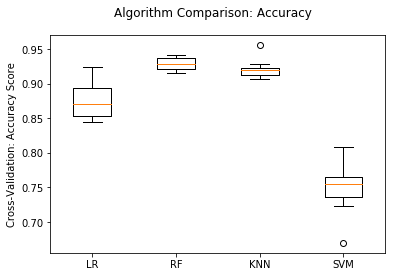

LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine
Runtime: 1527550656.750418


In [27]:
start=time.time()

CompareModels(x_train,y_train,x_test,y_test)

ModelNames()

end=time.time()

runtime=end-start

print("Runtime: "+str(runtime)+"s")

## 3.3 Using HOG features extracted from images instead

### 3.3.1 HOG features extraction

In [10]:
X=X.transpose(0,2,3,1)

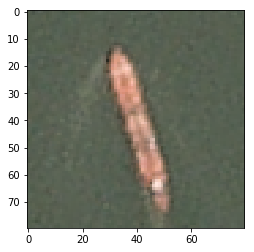

In [11]:
plt.imshow(X[51])
plt.show()

In [12]:
X_gray=[cv2.cvtColor(i,cv2.COLOR_RGB2GRAY) for i in X]

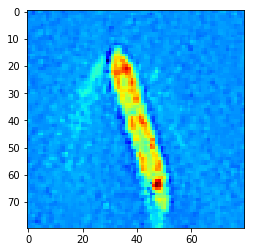

In [13]:
plt.imshow(X_gray[51])
plt.show()

In [14]:
ppc=16
hog_images=[]
hog_features=[]
for image in X_gray:
    fd,hog_image=hog(image,orientations=8,pixels_per_cell=(ppc,ppc),cells_per_block=(4,4),block_norm='L2',visualise=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

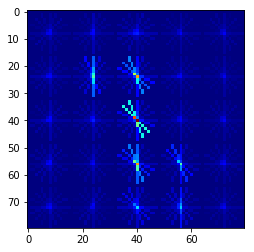

In [15]:
plt.imshow(hog_images[51])
plt.show()

### 3.3.2 Split the dataset

In [16]:
x_train,x_test,y_train,y_test=train_test_split(hog_features,data_labels,test_size=0.2,random_state=42)

### 3.3.3 Comparison


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.958929 (0.014644)
RF: 0.953571 (0.012658)
KNN: 0.966518 (0.010229)
SVM: 0.900893 (0.022746)


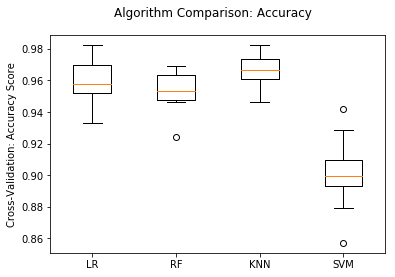

LR = Logistic Regression
RF = Random Forest
KNN = K-Nearest Neighbors
SVM = Support Vector Machine
Runtime: 27.46461319923401s


In [23]:
start=time.time()

CompareModels(x_train,y_train,x_test,y_test)

ModelNames()

end=time.time()

runtime=end-start

print("Runtime: "+str(runtime)+"s")

# 4. Convolutional Neural Network (CNN) implementation

## 4.1 Data preprocessing

### 4.1.1 One-hot encoding

In [8]:
Y=np_utils.to_categorical(data_labels,2)

(2800, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [ ]:
print(Y.shape)
print(Y)

### 4.1.2 Shuffle

In [11]:
indexes=np.arange(2800)
np.random.shuffle(indexes)
X=X[indexes].transpose([0,2,3,1])
Y=Y[indexes]

### 4.1.3 Normalization

In [12]:
X=X/255

## 4.2 Train Convolutional Neural Network

### 4.2.1 Model design

In [14]:
np.random.seed(42)

model=Sequential()

model.add(Conv2D(32,(3,3),padding='same',input_shape=(80, 80, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32,(10,10),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))

plot_model(model,to_file='model.png',show_shapes=True)

### 4.2.2 Optimization setup

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0,amsgrad=False),
    metrics=['accuracy'])

Train on 2240 samples, validate on 560 samples
Epoch 1/32
 - 18s - loss: 0.4762 - acc: 0.7978 - val_loss: 0.3215 - val_acc: 0.8875
Epoch 2/32
 - 16s - loss: 0.2610 - acc: 0.8933 - val_loss: 0.2491 - val_acc: 0.8982
Epoch 3/32
 - 18s - loss: 0.2095 - acc: 0.9188 - val_loss: 0.2034 - val_acc: 0.9179
Epoch 4/32
 - 17s - loss: 0.1768 - acc: 0.9268 - val_loss: 0.1503 - val_acc: 0.9446
Epoch 5/32
 - 17s - loss: 0.1497 - acc: 0.9411 - val_loss: 0.1609 - val_acc: 0.9429
Epoch 6/32
 - 17s - loss: 0.1481 - acc: 0.9429 - val_loss: 0.2073 - val_acc: 0.9268
Epoch 7/32
 - 16s - loss: 0.1546 - acc: 0.9397 - val_loss: 0.1597 - val_acc: 0.9286
Epoch 8/32
 - 18s - loss: 0.1280 - acc: 0.9487 - val_loss: 0.0983 - val_acc: 0.9607
Epoch 9/32
 - 18s - loss: 0.1087 - acc: 0.9603 - val_loss: 0.0919 - val_acc: 0.9732
Epoch 10/32
 - 16s - loss: 0.1045 - acc: 0.9585 - val_loss: 0.0836 - val_acc: 0.9696
Epoch 11/32
 - 18s - loss: 0.1006 - acc: 0.9612 - val_loss: 0.0690 - val_acc: 0.9786
Epoch 12/32
 - 16s - loss: 

### 4.2.3 Train

In [ ]:
history=model.fit(X,Y,batch_size=32,epochs=32,validation_split=0.2,shuffle=True,verbose=2)

### 4.2.4 Plot curves

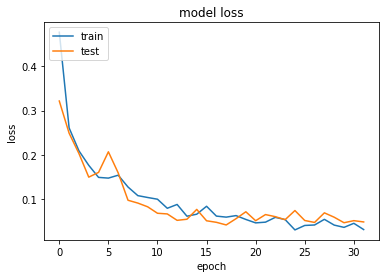

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

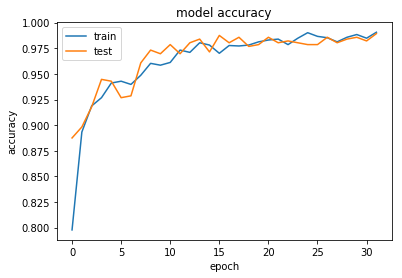

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

# 5. Sliding Windows Detection Based on CNN

## 5.1 Download image and visualize

In [18]:
image=cv2.imread('/Users/howard/Desktop/ECE228/Project/Data/scenes/sfbay_1.png',flags=cv2.IMREAD_COLOR)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
print(image.shape)

(1777, 2825, 3)


In [19]:
height=image.shape[0]
width=image.shape[1]

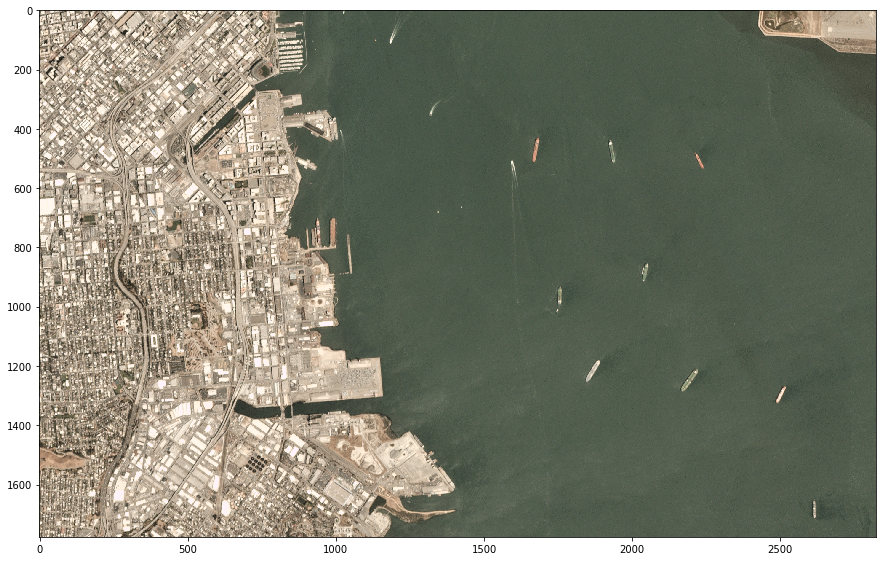

In [20]:
plt.figure(1,figsize=(15, 30))

plt.imshow(image)

plt.show()

In [22]:
image=image.transpose(2,0,1)
image=np.array(image).astype('uint8')

In [23]:
image.shape

(3, 1777, 2825)

## 5.2 Search on the image

In [24]:
def cutting(x,y):
    area_study=np.arange(3*80*80).reshape(3,80,80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j]=image[0][y+i][x+j]
            area_study[1][i][j]=image[1][y+i][x+j]
            area_study[2][i][j]=image[2][y+i][x+j]
    area_study=area_study.reshape([-1,3,80,80])
    area_study=area_study.transpose([0,2,3,1])
    area_study=area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [25]:
def not_near(x,y,s,coordinates):
    result=True
    for e in coordinates:
        if x+s>e[0][0] and x-s<e[0][0] and y+s>e[0][1] and y-s<e[0][1]:
            result=False
    return result

In [26]:
def show_ship(x,y,acc,thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x-th]=-1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x+th+80]=-1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y-th][x+i]=-1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+th+80][x+i]=-1

X:1640 Y:410  [[ 0.02364146  0.97635853]]


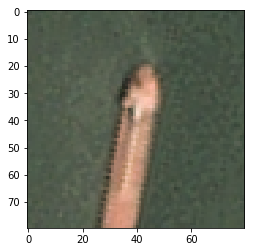

X:1890 Y:420  [[ 0.00145385  0.99854612]]


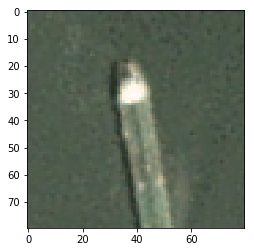

X:2180 Y:460  [[ 0.03832619  0.96167386]]


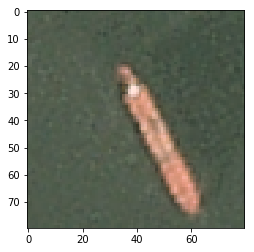

X:870 Y:480  [[ 0.09057874  0.90942127]]


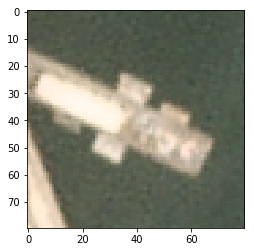

X:1560 Y:500  [[ 0.01467086  0.98532909]]


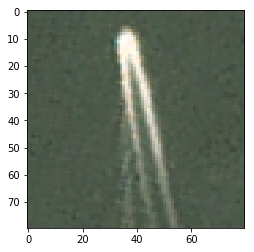

X:900 Y:690  [[ 0.02377588  0.97622412]]


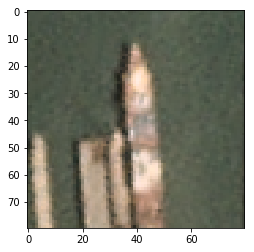

X:1000 Y:730  [[ 0.07775028  0.92224967]]


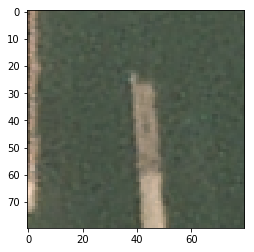

X:1720 Y:920  [[ 0.06625549  0.93374455]]


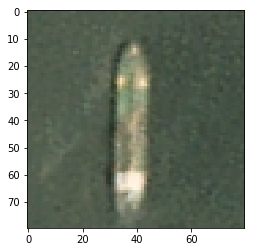

X:1830 Y:1170  [[ 0.00453485  0.99546522]]


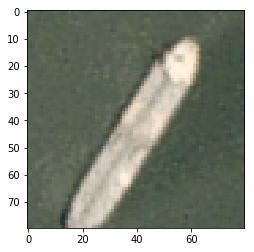

X:2160 Y:1200  [[ 0.04844705  0.95155293]]


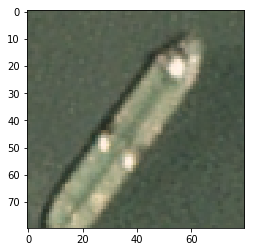

X:2470 Y:1250  [[ 0.07284879  0.9271512 ]]


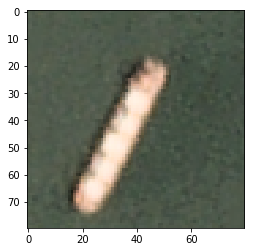

X:1340 Y:1540  [[ 0.03916604  0.96083397]]


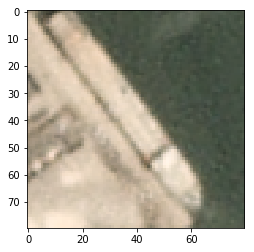

X:1300 Y:1650  [[ 0.0513266   0.94867337]]


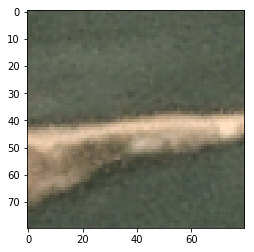

X:2740 Y:1690  

In [27]:
step=10
coordinates=[]
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step)):
        area=cutting(x*step,y*step)
        result=model.predict(area)
        if result[0][1]>0.90 and not_near(x*step,y*step,88,coordinates):
            coordinates.append([[x*step,y*step],result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [33]:
for e in coordinates:
    show_ship(e[0][0],e[0][1],e[1][0][1])

## 5.3 Show bounding boxes on image

In [34]:
image=image.transpose(1,2,0)
image.shape

(1777, 2825, 3)

In [3]:
plt.figure(1,figsize=(15,30))

plt.subplot(3,1,1)
plt.imshow(image)

plt.show()

NameError: name 'image' is not defined